In [1]:
import pandas as pd
import numpy as np

In [2]:
cc_icd_chapter=pd.read_csv('cc_icd_chapter.csv',usecols=['TEXT','ICD9_CHAPTER'])
cc_icd_chapter=cc_icd_chapter.dropna()
cc_icd_chapter = cc_icd_chapter.reset_index(drop=True)
cc_icd_chapter

,TEXT,ICD9_CHAPTER
0,"81 yo F smoker w/ COPD, severe TBM, s/p trache...",390-459
1,COPD exacerbation/Shortness of Breath,390-459
2,Mr. [**Known lastname 1829**] was seen at [**H...,520-579
3,Meningioma,240-279
4,Hypoxia,390-459
...,...,...
75935,Diarrhea and weakness,460-519
75936,low back pain,290-319
75937,hemoptysis,460-519
75938,Unresponsiveness,800-999


<AxesSubplot:>

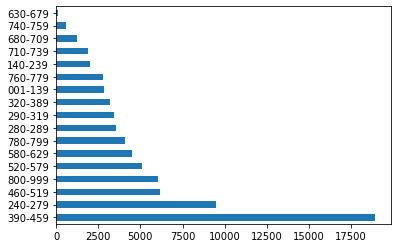

In [3]:
cc_icd_chapter['ICD9_CHAPTER'].value_counts()[:17].plot(kind='barh')

In [17]:
# counts = dict()
# # counts = (['001-139','140-239','240-279','280-289', '290-319', '320-389', '390-459','460-519','520-579', '580-629', 
# #     '630-679','680-709','710-739','740-759','760-779','780-799','800-999'])

# cc_icd_500 = pd.DataFrame(columns=['TEXT','ICD9_CHAPTER'])
# for i in range(0,75940):
#     cur = cc_icd_chapter['ICD9_CHAPTER'].iloc[i]
#     counts[cur] = counts.get(cur, 0) + 1
#     if counts[cur] > 100:
#         continue
#     else:
#         cc_icd_500=cc_icd_500.append({
#                         'TEXT': cc_icd_chapter['TEXT'].iloc[i],
#                         'ICD9_CHAPTER' : cur
#                         },ignore_index=True)

In [4]:
x=cc_icd_chapter['TEXT']
x.head()

0    81 yo F smoker w/ COPD, severe TBM, s/p trache...
1                COPD exacerbation/Shortness of Breath
2    Mr. [**Known lastname 1829**] was seen at [**H...
3                                           Meningioma
4                                              Hypoxia
Name: TEXT, dtype: object

In [5]:
y=cc_icd_chapter['ICD9_CHAPTER']
y.head()

0    390-459
1    390-459
2    520-579
3    240-279
4    390-459
Name: ICD9_CHAPTER, dtype: object

In [6]:
# import re

# text_list=[]
# for text in x:
#     cur_text = re.sub('[^a-zA-Z]',' ',text) # only English 
#     cur_text = cur_text.lower()
#     cur_text = cur_text.split()
#     cur_text = ' '.join(cur_text)
#     text_list.append(cur_text)
    
# from keras.preprocessing.text import one_hot
# from keras.preprocessing.sequence import pad_sequences

# w_vec = [one_hot(word,10000)for word in text_list]
# w_vec = np.array(w_vec) 
# length = 218
# embed = pad_sequences(w_vec, padding='pre', maxlen=length)
# embed.shape

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=218)
word_vectorizer.fit(x)

word_v=word_vectorizer.transform(x)
embed=word_v.toarray()*9999
embed.shape

(75940, 218)

In [8]:
yv=np.zeros((embed.shape[0],17))

# from sklearn.preprocessing import LabelEncoder
# lb = LabelEncoder()
# yv = lb.fit_transform(yv)

chapter = ['001-139','140-239','240-279','280-289', '290-319', '320-389', '390-459','460-519','520-579', '580-629', 
    '630-679','680-709','710-739','740-759','760-779','780-799','800-999']
for i in range(0,embed.shape[0]):
    index = chapter.index(y[i])
    yv[i,index]=1

In [9]:
from keras.models import Sequential
from keras.layers import Dropout, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten, Dense
from keras.layers.normalization import BatchNormalization

model=Sequential()
model.add(Embedding(input_dim=10000,output_dim=200,input_length=218))
model.add(Conv1D(kernel_size=1, filters=400,padding='valid',activation='relu'))
# model.add(Conv1D(kernel_size=1, filters=400,padding='valid',activation='relu'))
# model.add(Conv1D(kernel_size=1, filters=400,padding='valid',activation='relu'))
# model.add(Conv1D(kernel_size=1, filters=400,padding='valid',activation='relu'))
# model.add(Conv1D(kernel_size=1, filters=400,padding='valid',activation='relu'))
model.add(MaxPooling1D(pool_size=218))
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(units = 17,activation='sigmoid'))
model.add(Dropout(rate=0.5))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Using TensorFlow backend.
2022-05-08 20:34:23.353917: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-08 20:34:23.354149: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 218, 200)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 218, 400)          80400     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 400)            0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dropout (Dropout)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 17)                6817      
_________________________________________________________________
dropout_1 (Dropout)          (None, 17)                0

In [10]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(embed,yv,test_size=0.3, random_state=1)

In [11]:
m = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=5,batch_size=100)

Train on 53158 samples, validate on 22782 samples
Epoch 1/5
53158/53158 [==============================] - 170s 3ms/sample - loss: 0.6984 - accuracy: 0.8772 - val_loss: 0.2165 - val_accuracy: 0.9412
Epoch 2/5
53158/53158 [==============================] - 170s 3ms/sample - loss: 0.5595 - accuracy: 0.9412 - val_loss: 0.2157 - val_accuracy: 0.9412
Epoch 3/5
53158/53158 [==============================] - 169s 3ms/sample - loss: 0.5592 - accuracy: 0.9412 - val_loss: 0.2159 - val_accuracy: 0.9412
Epoch 4/5
53158/53158 [==============================] - 170s 3ms/sample - loss: 0.5550 - accuracy: 0.9412 - val_loss: 0.2147 - val_accuracy: 0.9412
Epoch 5/5
53158/53158 [==============================] - 170s 3ms/sample - loss: 0.5574 - accuracy: 0.9412 - val_loss: 0.2146 - val_accuracy: 0.9412


In [12]:
predict_x=model.predict(x_test) 

In [13]:
predict_x

array([[0.01609188, 0.01229012, 0.05754665, ..., 0.01472524, 0.0255484 ,
        0.03507364],
       [0.01464   , 0.01560938, 0.05801457, ..., 0.01745555, 0.02198619,
        0.03425834],
       [0.01054257, 0.00662795, 0.08056772, ..., 0.00779715, 0.02001184,
        0.02257916],
       ...,
       [0.015376  , 0.01578143, 0.05721858, ..., 0.02195472, 0.02285013,
        0.03832996],
       [0.01321343, 0.01126015, 0.0716936 , ..., 0.0116387 , 0.02411622,
        0.0357984 ],
       [0.01468429, 0.01561433, 0.05822185, ..., 0.01564315, 0.02451331,
        0.03575116]], dtype=float32)

In [14]:
pred_labels = np.zeros((x_test.shape[0],17))
for i in range(0,len(predict_x)):
    m_i = np.where(predict_x[1]==np.max(predict_x[1]))
    pred_labels[i][m_i] = 1
pred_labels.shape

(22782, 17)

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy score', accuracy_score(y_test, pred_labels))
print('Micro precision', precision_score(y_test, pred_labels, average='micro'))
print('Micro recall', recall_score(y_test, pred_labels, average='micro'))
print('Micro f1-score', f1_score(y_test, pred_labels, average='micro'))
print('Macro precision', precision_score(y_test, pred_labels, average='macro'))
print('Macro recall', recall_score(y_test, pred_labels, average='macro'))
print('Macro f1-score', f1_score(y_test, pred_labels, average='macro'))
print('Weighted precision', precision_score(y_test, pred_labels, average='weighted'))
print('Weighted recall', recall_score(y_test, pred_labels, average='weighted'))
print('Weighted f1-score', f1_score(y_test, pred_labels, average='weighted'))

Accuracy score 0.24817838644543938
Micro precision 0.24817838644543938
Micro recall 0.24817838644543938
Micro f1-score 0.24817838644543938


/Users/gaoyueyi/opt/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro precision 0.01459872861443761
Macro recall 0.058823529411764705
Macro f1-score 0.02339205481038948
Weighted precision 0.06159251149866185
Weighted recall 0.24817838644543938
Weighted f1-score 0.09869184111425756


/Users/gaoyueyi/opt/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
predict_xt=model.predict(x_train) 

for i in range(0,len(predict_xt)):
    m_i = np.where(predict_xt[1]==np.max(predict_xt[1]))
    predict_xt[i][m_i] = 1
pred_tlabels = np.round(predict_xt).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print('Accuracy score', accuracy_score(y_train, pred_tlabels))
print('Micro precision', precision_score(y_train, pred_tlabels, average='micro'))
print('Micro recall', recall_score(y_train, pred_tlabels, average='micro'))
print('Micro f1-score', f1_score(y_train, pred_tlabels, average='micro'))
print('Macro precision', precision_score(y_train, pred_tlabels, average='macro'))
print('Macro recall', recall_score(y_train, pred_tlabels, average='macro'))
print('Macro f1-score', f1_score(y_train, pred_tlabels, average='macro'))
print('Weighted precision', precision_score(y_train, pred_tlabels, average='weighted'))
print('Weighted recall', recall_score(y_train, pred_tlabels, average='weighted'))
print('Weighted f1-score', f1_score(y_train, pred_tlabels, average='weighted'))

Accuracy score 0.24931336769630158
Micro precision 0.24931336769630158
Micro recall 0.24931336769630158
Micro f1-score 0.24931336769630158


/Users/gaoyueyi/opt/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Macro precision 0.014665492217429505
Macro recall 0.058823529411764705
Macro f1-score 0.023477683976874844
Weighted precision 0.06215715531207128


/Users/gaoyueyi/opt/anaconda3/envs/cs/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Weighted recall 0.24931336769630158
Weighted f1-score 0.09950610778573082
